In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import tomli
from matplotlib.gridspec import GridSpec

from generate_data import sample_init_state
from unicycle import (InferenceConfig, SimulationConfig, Unicycle,
                      simulate_system)
from utils import set_size

base_path = Path(os.getcwd()).parent

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

Params

In [3]:
config = 'configs/config.toml'
abs_config_path = (base_path / config).resolve()
with open(abs_config_path, 'rb') as f:
    data = tomli.load(f)
    simulation_cfg = SimulationConfig(**data['simulation'])

Evaluations

In [4]:
# DeepONet inference config
deeponet_name = 'DeepONet'
deeponet_P1 = (base_path / f'models/Unicycle_delays_25_60_dx_01_DeepONet_P1.pth').resolve()
deeponet_P2 = (base_path / f'models/Unicycle_delays_25_60_dx_01_DeepONet_P2.pth').resolve()
DeepONet_cfg = InferenceConfig(deeponet_name, deeponet_P1, deeponet_P2)

# FNO inference config
fno_name = 'FNO'
fno_P1 = (base_path / f'models/Unicycle_delays_25_60_dx_01_FNO_P1.pth').resolve()
fno_P2 = (base_path / f'models/Unicycle_delays_25_60_dx_01_FNO_P2.pth').resolve()
FNO_cfg = InferenceConfig(fno_name, fno_P1, fno_P2)

NameError: name '__file__' is not defined

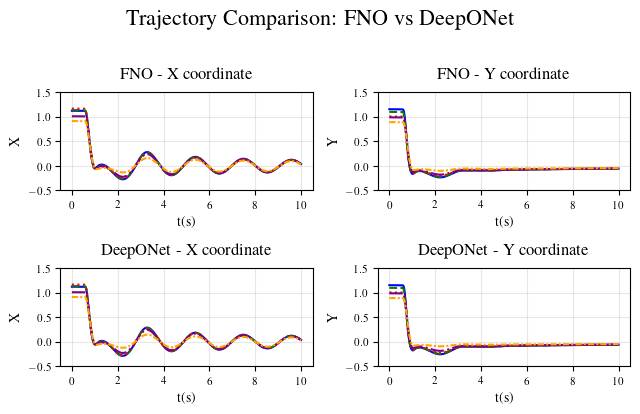

In [ ]:
num_of_traj = 5
savefig = 'multiple_trajectories_all'

# Create figure with GridSpec
fig = plt.figure(figsize=set_size(469.75502, 1, (2, 2), height_add=0))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1])
fig.suptitle('Trajectory Comparison: FNO vs DeepONet', fontsize=16, y=1.02)

# Define line styles (colors + line types)
line_styles = [
    {'color': 'blue', 'linestyle': '-', 'linewidth': 1.5},
    {'color': 'green', 'linestyle': '--', 'linewidth': 1.5},
    {'color': 'red', 'linestyle': ':', 'linewidth': 1.5},
    {'color': 'purple', 'linestyle': '-.', 'linewidth': 1.5},
    {'color': 'orange', 'linestyle': (0, (3, 1, 1, 1)), 'linewidth': 1.5}  # Custom dash pattern
]

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # FNO X
ax2 = fig.add_subplot(gs[0, 1])  # FNO Y
ax3 = fig.add_subplot(gs[1, 0])  # DeepONet X
ax4 = fig.add_subplot(gs[1, 1])  # DeepONet Y

# Store all trajectories and time stamps
all_trajectories = {
    'fno_x': [],
    'fno_y': [],
    'deeponet_x': [],
    'deeponet_y': []
}
time_stamps = None  # Will be set during the first simulation

for i in range(num_of_traj):
    # Create simulations
    init_state = sample_init_state()
    fno_uni = Unicycle(init_state, simulation_cfg, FNO_cfg)
    deeponet_uni = Unicycle(init_state, simulation_cfg, DeepONet_cfg)

    # Simulate
    fno_states, _, _, _, _ = simulate_system(fno_uni)
    deeponet_states, _, _, _, _ = simulate_system(deeponet_uni)
    
    # Store trajectories
    all_trajectories['fno_x'].append(fno_states[:, 0])  # X position
    all_trajectories['fno_y'].append(fno_states[:, 1])  # Y position
    all_trajectories['deeponet_x'].append(deeponet_states[:, 0])
    all_trajectories['deeponet_y'].append(deeponet_states[:, 1])
    
    # Store time stamps (assuming they're the same for all simulations)
    if time_stamps is None:
        time_stamps = simulation_cfg.t

# Plotting function with time stamps
def plot_trajectories(ax, trajectories, title, ylabel):
    for i, traj in enumerate(trajectories):
        ax.plot(time_stamps, traj,  # Use time_stamps for x-axis
                label=f'Traj {i+1}',
                color=line_styles[i]['color'],
                linestyle=line_styles[i]['linestyle'],
                linewidth=line_styles[i]['linewidth'])
    
    ax.set_title(title, pad=10)
    ax.set_xlabel('t(s)')  # Updated x-label to indicate time units
    ax.set_ylabel(ylabel)
    ax.set_yticks([-0.5, 0, 0.5, 1.0, 1.5])  # Enforce y-ticks
    ax.grid(True, alpha=0.3)
    # ax.legend(loc='upper right')

# Plot all trajectories
plot_trajectories(ax1, all_trajectories['fno_x'], 'FNO - X coordinate', 'X')
plot_trajectories(ax2, all_trajectories['fno_y'], 'FNO - Y coordinate', 'Y')
plot_trajectories(ax3, all_trajectories['deeponet_x'], 'DeepONet - X coordinate', 'X')
plot_trajectories(ax4, all_trajectories['deeponet_y'], 'DeepONet - Y coordinate', 'Y')

plt.tight_layout()
plt.show()